In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gw_df = pd.read_csv('../data/richers_1764.csv')

distance = 3.086e22
gw_df = gw_df / distance

# for future use
sampling_period = 0.00024354078

### Analysis

- Signals truncated 0.04956055s before bounce and roughly 0.04956055s after bounce, as provided by Matt's research paper

- All y values are in distance * strain. Where all distances are 10 kpc or 3.086e22m. Strain is * 1e-21.

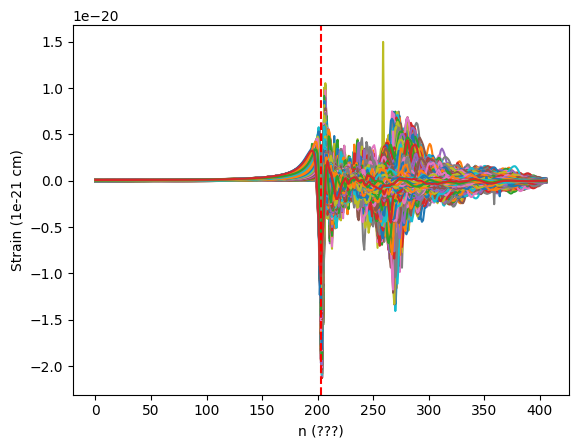

In [6]:
gw_df.plot(legend=False)

plt.xlabel('n (???)')
plt.ylabel('Strain (cm)')

# the core bounce is at n = 203
plt.axvline(x=203, color='r', linestyle='--')

plt.show()

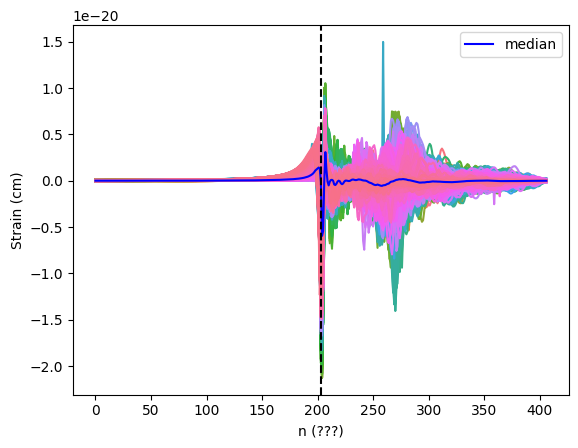

In [10]:
# convert the DataFrame from wide format to long format for seaborn
gw_df_long = pd.melt(gw_df.reset_index(), id_vars='index')

gw_df_long.columns = ['n (???)', 'Line', 'Strain (cm)']

# confidence intervals
sns.lineplot(x='n (???)', y='Strain (cm)', hue='Line', data=gw_df_long, errorbar=('ci', 95), n_boot=1000, legend=False)

median_line = gw_df.median(axis=1)
plt.plot(median_line.index, median_line.values, 'b-', label='median')

# the core bounce is at n = 203
plt.axvline(x=203, color='black', linestyle='--')  

plt.legend()
plt.show()